# Final Number Model Inference

### Set up

In [1]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
import json

### retrieve training job to create estimator

In [2]:
# Use TrainingJobName to create estimator
AC_TrainingJobName = "object-detection-2021-08-29-09-01-26-558" #1000 balanced
SVHN_TrainingJobName = "object-detection-2021-09-22-07-40-46-799" # 13000 balanced
EMN_TrainingJobName = "object-detection-2021-09-08-19-39-57-997" # 400 unbalanced
EMN_SVHN_TrainingJobName = "object-detection-2021-09-24-06-29-52-948" 
AC_SVHN_TrainingJobName = "object-detection-2021-09-24-07-36-34-283"

final_no_model = sagemaker.estimator.Estimator.attach(EMN_SVHN_TrainingJobName)


2021-09-10 09:27:29 Starting - Preparing the instances for training
2021-09-10 09:27:29 Downloading - Downloading input data
2021-09-10 09:27:29 Training - Training image download completed. Training in progress.
2021-09-10 09:27:29 Uploading - Uploading generated training model
2021-09-10 09:27:29 Completed - Training job completed


### Hosting

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the ml.p3.2xlarge instance to train, but we choose to host the model on the less expensive cpu instance, ml.m4.xlarge. The endpoint deployment can be accomplished as follows:

In [ ]:
final_no_detector = final_no_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

---------------

### Inference through frame folder

In [13]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=8, color='white')
            
        plt.show()

### Evaluating accuracy

In [188]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [143]:
def get_num(x_list, num_list):
    # arrange number list incresingly by x0, in the image, numbers are left to right
    sorted_no_list =  [x for y, x in sorted(zip(x_list, num_list))]            
    no_str = ''.join(map(str, sorted_no_list))
    return no_str

### Load manifest labels

using the manifest data to compare detections and ground truth annotations

In [83]:
with open('0917_gtdata_analyse/all_output.manifest', 'r') as f:
    # use list intersection to find how many digits are correctly detected
    output = [json.loads(line.strip()) for line in f.readlines()]

### Visualise detection and calculating accuracy

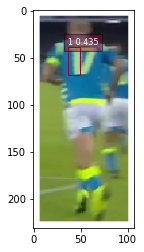

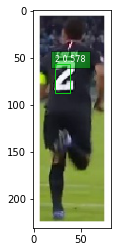

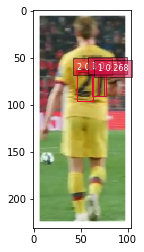

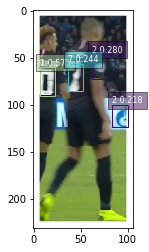

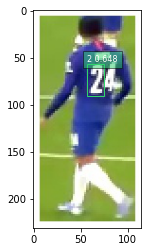

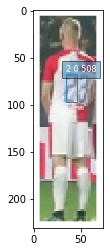

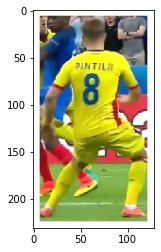

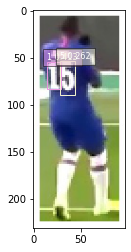

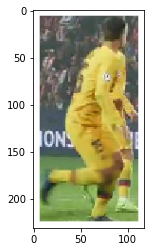

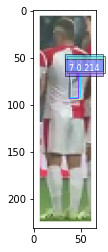

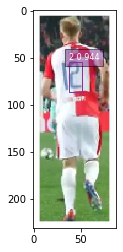

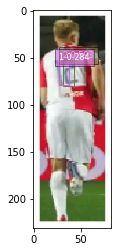

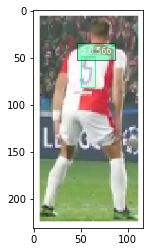

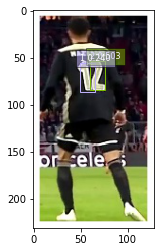

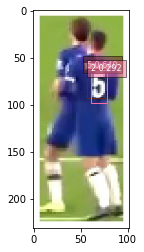

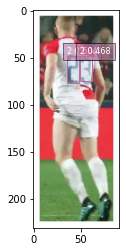

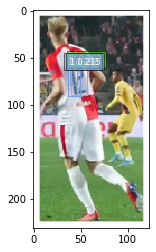

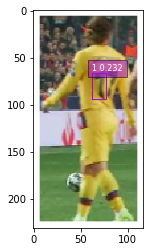

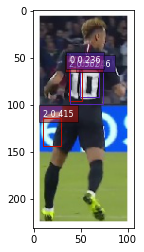

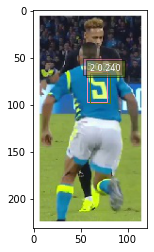

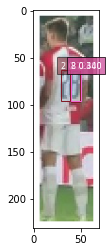

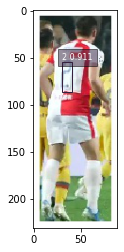

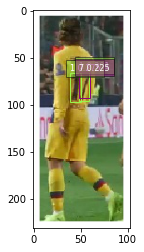

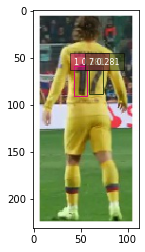

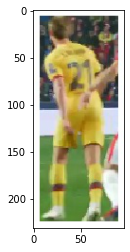

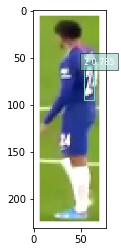

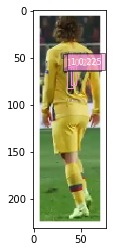

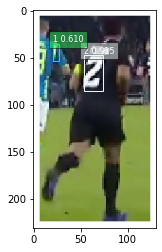

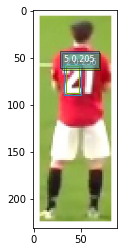

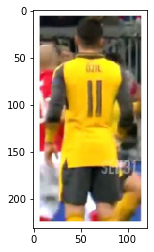

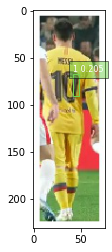

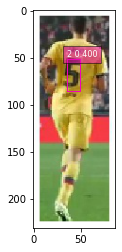

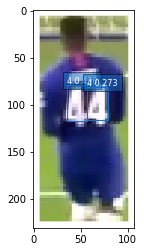

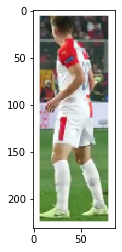

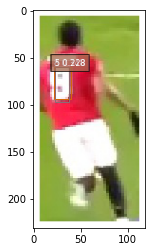

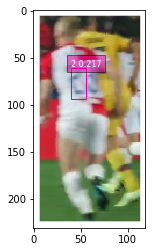

digit acc : 62.5%, num acc: 19.444444444444446%


In [198]:
import os
import math
from matplotlib import pyplot as plt
import json 

# Setting detector
object_categories = ['0','1','2','3','4','5','6','7','8','9']
threshold = 0.2
final_no_detector.__setattr__(final_no_detector.content_type, 'image/jpeg')

# Test imgs
test_folder = "0910-players-test-set"
tnames = os.listdir(test_folder)

total_digit_acc = 0
total_num_acc = 0

for tname in enumerate(tnames):
    
    # detections results lists
    temp_det_num_list = []
    temp_det_x_list = []
    # ground truth annotation lists
    temp_anno_num_list = []
    temp_anno_x_list = []
    
    # use sagemaker predictor to make predictions
    with open('{}/{}'.format(test_folder,tname[1]), 'rb') as image:
        f = image.read()
        b = bytearray(f)
    results =final_no_detector.predict(b,initial_args={'ContentType': 'image/jpeg'})
    detections = json.loads(results)

    # looping digits predicted
    for det in detections['prediction']:
        (klass, score, x0, y0, x1, y1) = det
        if score < threshold:
                continue
        temp_det_num_list.append(int(klass))
        temp_det_x_list.append(x0)
    
    # find current image's responding annotation in manifest file
    for i in output:
        if i["source-ref"].split('/')[-1].lower()== tname[1].lower():
            try:
                for anno in i["number-detector-emn-train-labelingjob"]["annotations"]:
                    temp_anno_num_list.append(anno["class_id"])
                    temp_anno_x_list.append(anno["left"])
            except:
                for anno in i["number-detector-emn-val-labelingjob"]["annotations"]:
                    temp_anno_num_list.append(anno["class_id"])
                    temp_anno_x_list.append(anno["left"])
    
    # digit accuracy
    if len(temp_det_num_list) > 0:
        digit_accuracy = 100 * (len(intersection(temp_anno_num_list,temp_det_num_list))/len(temp_det_num_list)) 
        total_digit_acc += digit_accuracy
    else:
        digit_accuracy = 0
        total_digit_acc += digit_accuracy
    
    # num accuracy
    if get_num(temp_det_x_list,temp_det_num_list)==get_num(temp_anno_x_list,temp_anno_num_list):
        total_num_acc += 1
    else:
        total_num_acc += 0
            
    # Visualize the detections.
    visualize_detection('{}/{}'.format(test_folder,tname[1]), detections['prediction'], object_categories, threshold)

print("digit acc : {}%, num acc: {}%".format((total_digit_acc/len(tnames)),((total_num_acc)/len(tnames))*100))

### Delete the Endpoint

In [199]:
sagemaker.Session().delete_endpoint(final_no_detector.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
